In [1]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import sspspace
import scipy

So with the novelty detection algorithm as presented in the paper, the output current has a magnitude that is proportional to the Probability Density Function (pdf) of the observed data.  This is problematic in two ways:  first, we don't know what that constant of proportionality is, and second the magnitude of the pdf is kind of a weird measure anyway.  You can't just pick a threshold and say that if you reject values lower than that threshold, you'll always be rejecting some fixed percentage of the training data.  The amount of data you'll reject that way depends on your distribution.  For example, here's two Gaussian distributions with different $\sigma$ values.  

0.4467966022438017
0.09260878681232662


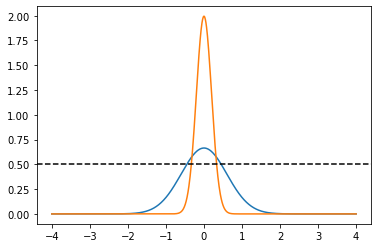

In [25]:
x = np.linspace(-4, 4, 1000)
dx = x[1]-x[0]

d1 = scipy.stats.norm.pdf(x, loc=0, scale=0.6)
d2 = scipy.stats.norm.pdf(x, loc=0, scale=0.2)

threshold = 0.5

plt.plot(x, d1)
plt.plot(x, d2)
plt.axhline(threshold, ls = '--', c='k')

print(np.sum(d1[d1<threshold])*dx)
print(np.sum(d2[d2<threshold])*dx)


For the blue one, if we set a threshold of 0.5, we reject 45% of the data.  For the orange one, if we set a threshold of 0.5, we reject 9% of the data.

The actual threshold we want if we want to reject 10% of the data would be the weighted 0.1 quantile of the linearly sampled pdf (if we actually had the pdf value for each of the sample points in the training data, then we'd just need the 0.1 quantile of those values, but since we have the linearly sampled pdf instead we need to do a weighted quantile):

0.09929307041278154
0.09260878681232662


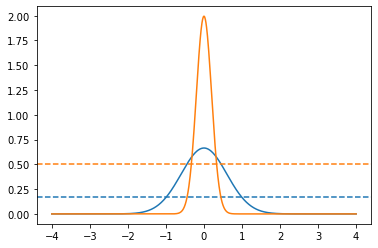

In [47]:
from statsmodels.stats.weightstats import DescrStatsW
t1 = DescrStatsW(data=d1, weights=d1).quantile(probs=np.array([0.1]), return_pandas=False)
t2 = DescrStatsW(data=d2, weights=d2).quantile(probs=np.array([0.1]), return_pandas=False)


line, = plt.plot(x, d1)
plt.axhline(t1, ls = '--', c=line.get_color())

line, = plt.plot(x, d2)
plt.axhline(t2, ls = '--', c=line.get_color())

print(np.sum(d1[d1<t1])*dx)
print(np.sum(d2[d2<t2])*dx)


Okay, so much for pdfs.  Now what can we do about the fact that the output of the model is proportional to the pdf, and this constant of proportionality increases as we train the network?

Well, the trick I mentioned to take that constantly increasing value and turn it into something that is more flat was to divide by the number of training data items seen so far.  So the output would be $\sum_i a_i w_i /N$, where $N$ is the number of samples seen so far.  Since all we're doing is scaling the output, the result is still proportional to the pdf, but now we don't have that annoying growth in the magnitude.

But, there's another way to think of this.  After all, $w_i$ starts at zero and uses the learning rule $\Delta w_i = a_i / \sum_j a_j$.  So we're just adding up the (normalized) activity of the $i$th neuron to get $w_i$.  So what happens if we bring $N$ into this equation?  What if we include $N$ as part of the weight, rather than something we do afterwards?  

Oh.  In that case, the weight is now the *mean* of the normalized activity, rather than the sum of the normalized activity.  That makes so much more sense.  That's not going to grow without bounds.  

And it also nicely connects to the version that has a decay term.  In that case, if we decay by $e^{-1/\tau}$ and scale our activity by ${1/\tau}$, then the weight will be the exponentially weighted mean of the activity with a time constant of $\tau$.  But since those are both means, the threshold that works for one should also work for the other (i.e. the outputs are on the same scale).

So, if we now think of our weights as the mean activity of the neuron they're connected to, does this tell us anything about where we should set our threshold?  

Maybe.  One thing we can do is just use the scaled-by-N version of the output, compute the 0.1 quantile of that output across all of our training data, and that should be our threshold.  But I'm curious if there might even be an analytic way of figuring out what that threshold is.  After all, it's just the sum of a whole bunch of randomly chosen neurons' activities, weighted by the average activity of that neuron.  